In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sklearn.preprocessing as preprocessing
from sklearn.svm import SVR
from sklearn.preprocessing import normalize
from datetime import datetime
from sklearn.model_selection import cross_val_score

In [2]:
%run GasLearningHelper.py 
%run ElasticSearchHelper.py
%run commonHelper.py
%run privateConfig.py
gasHelper = GasLearningHelper()
esHelper = ElasticSearchHelper()
cHelper = CommonHelper()
pConfig = PrivateConfig()

In [5]:
gasData = gasHelper.ReadGasData('ecas-export.db', '2017-12-01')
gasDataDelta = gasHelper.CreateDelta(gasData)
rangeQueryPart = esHelper.GetRange(gasDataDelta)
rangeQuery = cHelper.ReadJson('rangeQueryTemplate.json')

#es = Elasticsearch([{'host': 'search-es-domain-vu4rnb36e6pnimhdaaxry4jpyy.us-east-2.es.amazonaws.com', 'port': 80}])
#result = es.search(index="history-*", body=rangeQuery)

rangeQuery['aggs']['2']['aggs']['3']['date_range']['ranges'] = rangeQueryPart
# display(rangeQuery['aggs']['2']['aggs']['3']['date_range']['ranges'])
#display(rangeQuery)
cHelper.WriteJson('rangeQuery.json', rangeQuery)

In [17]:
#host, port = pConfig.ElasticSearchAwsHost()
#rangeResult = esHelper.Search(rangeQuery, host, port)
#display(rangeResult)
cHelper.WriteJson('rangeResult.json', rangeResult)

In [8]:
rangeResult = cHelper.ReadJson('rangeResult.json')

In [18]:
history = {}
# display(rangeResult['aggregations']['2']['buckets'])
for measure in rangeResult['aggregations']['2']['buckets']:
    data_sensor = {}
    for homeSensorData in measure['3']['buckets']:
        days = (homeSensorData['to'] - homeSensorData['from']) / 1000 / 60 / 60 / 24
        data_sensor[homeSensorData['key']] = { 
            'value': homeSensorData['1']['value'],
            'duration': days 
        }
    #display(measure['key'], homeSensorData['key'], homeSensorData['1']['value'])
    history[measure['key']] = data_sensor

In [10]:
## create X and Y
gas_Y = []
all_X = [] # all input data
pipetemp_X = [] # 'Boiler(0) Pipe MA'
exttemp_X = [] # 'Villebon(.) Station'
fl2temp_X = [] # "WoodSouth(2) Battery", "WoodNorth(2) Battery", "Stairs(2) Battery", "White(2) Battery"
inouttemp_X = [] # "WoodSouth(2) Battery", "WoodNorth(2) Battery", "Stairs(2) Battery", "White(2) Battery", 'Villebon(.) Station'
durations = [] # ['duration']
time_keys = []
for_range = history['Villebon(.) Station'].keys()

for key in for_range:
    duration = history['Villebon(.) Station'][key]['duration']
    exttemp = history['Villebon(.) Station'][key]['value']
    gas = [x for x in gasDataDelta if x.TimeKey() == key][0].Value() / duration 
    if duration > 8 or duration < 0.6:# or exttemp < 3.0 or exttemp > 9.0:
        continue
    gas_Y.append(gas)
    pipetemp_X.append([ history['Boiler(0) Pipe MA'][key]['value'] ])
    exttemp_X.append([ history['Villebon(.) Station'][key]['value'] ])
    fl2temp = np.mean([ history['WoodSouth(2) Battery'][key]['value'], history['WoodNorth(2) Battery'][key]['value'], \
                       history['Stairs(2) Battery'][key]['value'], history['White(2) Battery'][key]['value']])
    fl2temp_X.append([ fl2temp ])
    all_X.append([ history['Boiler(0) Pipe MA'][key]['value'], history['Villebon(.) Station'][key]['value'], fl2temp])
    inouttemp_X.append([ history['Villebon(.) Station'][key]['value'], fl2temp])
    durations.append(duration)
    time_keys.append(key)

X = all_X
indexes = np.arange(len(X))
sampling_X = np.vstack(np.linspace(np.amin(X), np.amax(X), num=41))
wieghts = cHelper.Normalize(durations)

In [11]:
# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.001)
svr_lin = SVR(kernel='linear', C=1e3)

In [12]:
fit_rbf = svr_rbf.fit(X, gas_Y, wieghts)
fit_lin = svr_lin.fit(X, gas_Y, wieghts)
y_rbf = fit_rbf.predict(X)
y_lin = fit_lin.predict(X)

In [13]:
# Evaluate the models using crossvalidation
scores = cross_val_score(svr_rbf, X, gas_Y, scoring="neg_mean_squared_error", cv=10)
print("RBF = {:.2f} (+/-{:.2f}) Score={:.2f}".format(-scores.mean(), scores.std(), svr_rbf.score(X, gas_Y, wieghts)))
scores = cross_val_score(svr_lin, X, gas_Y, scoring="neg_mean_squared_error", cv=10)
print("LIN = {:.2f} (+/-{:.2f}) Score={:.2f}".format(-scores.mean(), scores.std(), svr_lin.score(X, gas_Y, wieghts)))

log_indexes = [6, 7, 12]
for i in log_indexes:
    display([i, gas_Y[i], y_rbf[i], gas_Y[i] - y_rbf[i]])#, pipetemp_X[i], exttemp_X[i], fl2temp_X[i], time_keys[i], durations[i]])

RBF = 0.63 (+/-0.44) Score=0.93
LIN = 0.84 (+/-0.83) Score=0.92


[6, 15.257743517868628, 13.952484291956896, 1.3052592259117315]

[7, 14.747234042551854, 13.733647330448864, 1.01358671210299]

[12, 12.366467977173201, 12.26692610130883, 0.099541875864371576]

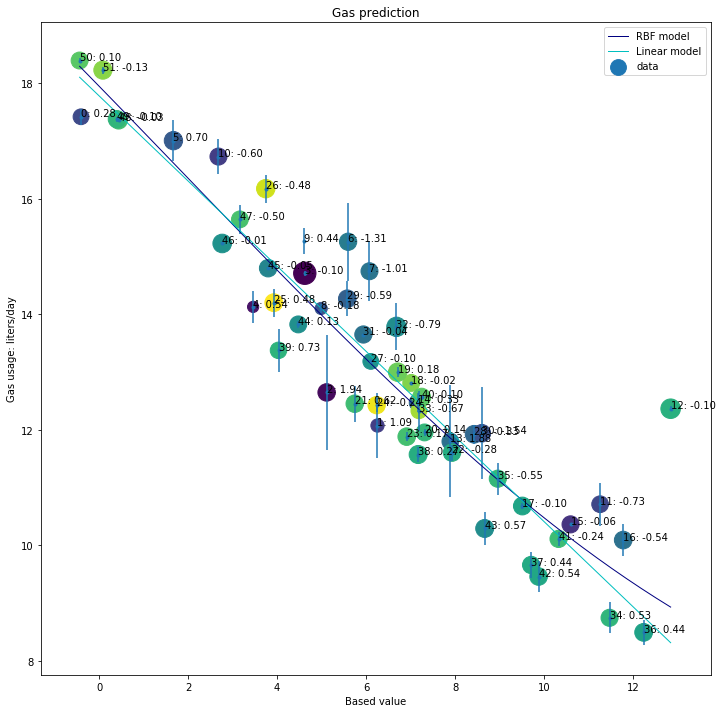

RBF = 1.05 (+/-1.02)
LIN = 0.96 (+/-1.05)


In [16]:
X = exttemp_X
sampling_X = np.vstack(np.linspace(np.amin(X), np.amax(X), num=41))

# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.001)
svr_lin = SVR(kernel='linear', C=1e3)
fit_rbf_1d = svr_rbf.fit(X, gas_Y, wieghts)
fit_lin_1d = svr_lin.fit(X, gas_Y, wieghts)

y_rbf = fit_rbf_1d.predict(sampling_X)
y_lin = fit_lin_1d.predict(sampling_X)
y_rbf_OnX = fit_rbf.predict(all_X)

barerror = cHelper.Normalize(np.absolute(y_rbf_OnX - gas_Y))*1.0
color = cHelper.Normalize(fl2temp_X)
annotation = y_rbf_OnX - gas_Y #np.array(fl2temp_X).reshape(len(fl2temp_X))
size = cHelper.Normalize(durations)*500.0

lw = 1
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.plot(sampling_X, y_rbf, color='navy', lw=lw, label='RBF model')
ax.plot(sampling_X, y_lin, color='c', lw=lw, label='Linear model')
ax.errorbar(X, gas_Y, yerr=barerror, fmt='.')
ax.scatter(X, gas_Y, c=color, s=size, label='data')
plt.title('Gas prediction')
plt.xlabel('Based value')
plt.ylabel('Gas usage: liters/day')
ax.legend()
#ax.rcParams["figure.figsize"] = [12, 12]

for i in range(len(annotation)):
    txt = "{}: {:.2f}".format(indexes[i], annotation[i])
    ax.annotate(txt, (X[i][0],gas_Y[i]), fontsize=10)

plt.show()

scores = cross_val_score(svr_rbf, X, gas_Y, scoring="neg_mean_squared_error", cv=10)
print("RBF = {:.2f} (+/-{:.2f})".format(-scores.mean(), scores.std()))
scores = cross_val_score(svr_lin, X, gas_Y, scoring="neg_mean_squared_error", cv=10)
print("LIN = {:.2f} (+/-{:.2f})".format(-scores.mean(), scores.std()))

In [361]:
y_rbf = svr_rbf.fit(X, gas_Y).predict(X)y_lin = svr_lin.fit(X, gas_Y).predict(X)
#y_poly = svr_poly.fit(X, gas_Y).predict(sampling_X)
log_indexes = [9, 10, 25, 33, 22, 27, 28]
for i in log_indexes: # 
    display([i, gas_Y[i], y_rbf[i], gas_Y[i] - y_rbf[i]])#, pipetemp_X[i], exttemp_X[i], fl2temp_X[i], time_keys[i], durations[i]])

[9, 5.574193548382026, 7.9690323931986402, -2.394838844816614]

[10, 1.7279999999893614, 1.8282652462658096, -0.10026524627644817]

[25, 6.281095353245055, 10.786664139468153, -4.5055687862230975]

[33, 12.366467977173201, 12.466619398157613, -0.1001514209844121]

[22, 19.741935483879413, 18.864070613058239, 0.87786487082117404]

[27, 18.835678670351868, 13.945764448187854, 4.8899142221640144]

[28, 20.164235294119432, 17.666904723869443, 2.4973305702499893]